<a href="https://colab.research.google.com/github/akshaypt7/amazon_sales_prediction/blob/main/project_01_06_embedding_using_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 14.1 MB/s 
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 1.2 MB 27.3 MB/s 
     |████████████████████████████████| 188 kB 59.2 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 280 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
# from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
# from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [3]:
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers import Dense, Flatten, Dropout, Input, Embedding, Reshape
from keras.layers import concatenate
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

from sklearn.model_selection import train_test_split
import math
import pandas as pd

In [4]:

#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *

In [6]:
infile = open('/content/gdrive/MyDrive/bluebook/df_main.pkl','rb')
df_main = pickle.load(infile)

In [7]:
df_main.head()

,date,Asin,Item Promo Discount,price,hour,Quantity,Invoice Amount
0,2021-01-04,B07KYFHTGF,0.00,1995.00,12.0,1.0,1995.00
1,2021-01-08,B07TM3LRVB,-56.75,1078.25,20.0,1.0,1078.25
2,2021-01-09,B08976V1BZ,-79.95,1519.05,22.0,1.0,1519.05
3,2021-01-11,B07TM3LRVB,0.00,1135.00,10.0,1.0,1135.00
4,2021-01-12,B08332221J,0.00,1499.00,12.0,1.0,1499.00


In [8]:
df_main = add_datepart(df_main,'date')

In [9]:
procs = [Categorify, FillMissing, Normalize]

We are changing the category variables and continous variables, because we think when we apply entity embedding, we get more value from these variables. (so we don't add quanity in both cat and cont)

In [10]:
cat = ['Asin',
 'hour',
 'Dayofweek',
 'Month',
 'Day',
 'Week',
 'Year',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [11]:
cont = ['Item Promo Discount',
 'price',
 'Invoice Amount',
 'Dayofyear',
 'Elapsed']

In [12]:
# SPLITS 
condition = (df_main.Year < 2020) | (df_main.Month < 8)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [13]:
splits = (list(train_idx),list(valid_idx))

In [14]:
dep_var = 'Quantity'

In [15]:
to_emb = TabularPandas(df_main,procs= procs, cat_names=cat, cont_names = cont, y_names=dep_var, splits = splits)

In [ ]:
to_emb.items.head(2)

,Asin,Item Promo Discount,price,hour,...,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2,0.393801,1.289015,13,...,1,1,1,0.704794
1,8,-1.607343,-0.424478,21,...,1,1,1,0.724514


In [16]:
x_train = to_emb.train.xs
y_train = to_emb.train.ys

x_valid = to_emb.valid.xs
y_valid = to_emb.valid.ys

In [17]:
upper_limit =max(df_main[dep_var].values)
lower_limit =min(df_main[dep_var].values)
upper_limit, lower_limit


(39.0, 1.0)

In [18]:
dls_emb = to_emb.dataloaders(bs=256)

In [19]:
learner_emb = tabular_learner(dls_emb,y_range= (1,39), layers= [250,100],n_out =1,loss_func= F.mse_loss, metrics=nn.L1Loss())

SuggestedLRs(valley=0.001737800776027143)

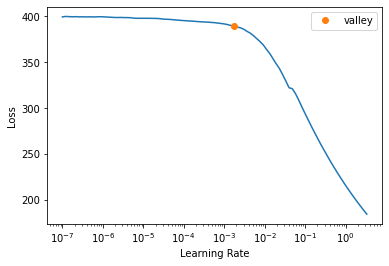

In [ ]:
learner_emb.lr_find()

In [20]:
learner_emb.fit(7,lr=1e-2)

epoch,train_loss,valid_loss,None,time
0,134.234924,11.277353,0.997926,00:00
1,59.618591,4.480414,0.901078,00:00
2,33.574810,10.256067,0.753429,00:00
3,19.825918,2.024719,0.972567,00:00
4,10.872602,0.430109,0.481111,00:00
5,6.133352,0.283235,0.299530,00:00
6,3.577172,0.269458,0.272369,00:00


Training with weight decay and without have a huge impact in the loss

In [ ]:
learner_emb.fit(7,lr=1e-2,wd=0.01)

epoch,train_loss,valid_loss,None,time
0,121.911285,2.662129,0.821382,00:00
1,57.037003,21.404379,1.088229,00:00
2,35.338722,0.399664,0.430365,00:00
3,20.743139,0.348871,0.454211,00:00
4,13.084545,0.238974,0.310623,00:00
5,7.328192,0.289073,0.397446,00:00
6,4.189364,0.606473,0.308012,00:00


In [21]:
preds, targs = learner_emb.get_preds()

In [22]:
MAE(targs,preds)

0.27236873

**MAE is 0.27**

### Now we need to get the embeddings from the learner

In [23]:
import torch


# Just right before the actual usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#### Creating Dataframe which will have all the embeddings

In [24]:
embedding_cols = ['Asin','hour','Dayofweek','Month','Day','Week','Year']

Instead of just the above columns, we decide to get embedding for all categories

In [26]:
new_df = pd.DataFrame()

for i,col in enumerate(cat):
  embedding = learner_emb.model.embeds[i]

  to_emb.items[col] = torch.tensor(to_emb.items[col].values).to(device).long()

  new_column = embedding(tensor(to_emb.items[col]))
  new_column = new_column.detach().numpy()


  

  for e_dim in range(embedding.embedding_dim):
    new_df[col+f'_{e_dim}'] = new_column[:,e_dim]

In [27]:
new_df.shape # there are total 63 embeddings

(10946, 81)

##### Merging the dataframes

In [28]:
df = df_main.copy()
for col in new_df.columns:
  df[col] = new_df[col]

for old_columns in cat:
  df.drop(old_columns,axis=1,inplace=True)

##### Save the Dataframe with embeddings



In [ ]:
# save_pickle('/content/gdrive/MyDrive/bluebook/df_with_embeddings.pkl',df)

In [29]:
import pickle

In [ ]:
def open_test_data():
    return open('/content/drive/MyDrive/bluebook/df_with_embeddings.pkl', 'rb')

with open_test_data() as f:
    df = pickle.load(f) 

In [ ]:
# df= load_pickle('/content/gdrive/MyDrive/bluebook/df_with_embeddings.pkl')

### Working with Embedding on Neural Network & Random Forest

In [31]:
cont_nn,cat_nn = cont_cat_split(df, dep_var=dep_var)

In [32]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [33]:
dls = to_nn.dataloaders(bs=256)

In [36]:
learner = tabular_learner(dls,y_range= (1,39), layers= [250,100],n_out =1,loss_func= F.mse_loss, metrics=nn.L1Loss())

SuggestedLRs(valley=0.0030199517495930195)

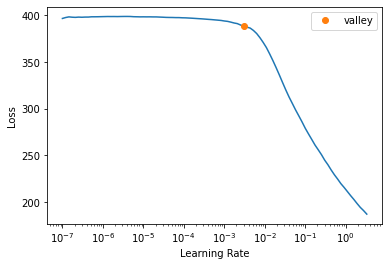

In [ ]:
learner.lr_find()

In [35]:
learner.fit(7,lr=1e-2)

epoch,train_loss,valid_loss,None,time
0,139.124435,121.771317,3.591618,00:00
1,118.894829,121.772789,3.507370,00:00
2,111.212471,121.768425,3.525963,00:00
3,108.561363,121.768738,3.518264,00:00
4,107.969688,121.769012,3.512348,00:00
5,107.850655,121.766212,3.517601,00:00
6,107.563812,121.764015,3.516802,00:00


In [37]:
learner.fit(7,lr=1e-2,wd=0.001)

epoch,train_loss,valid_loss,None,time
0,126.307610,84.267769,2.684967,00:00
1,91.452095,84.211006,2.540029,00:00
2,81.702370,84.203560,2.526334,00:00
3,76.852531,84.365059,2.525842,00:00
4,74.027740,84.205811,2.536857,00:00
5,73.182953,84.205643,2.532498,00:00
6,72.858650,84.197571,2.520708,00:00


The model with Entity Embedding didnt performed better than the one without.

**Model without entity embedding = MAE is 0.27**

**Model with entity embedding = MAE is 0.252**




In [38]:
preds, targs = learner.get_preds()

In [39]:
MAE(targs,preds)

2.520708

#### Random Forest

In [40]:
df.head()

,Item Promo Discount,price,Quantity,Invoice Amount,...,Is_year_end_2,Is_year_start_0,Is_year_start_1,Is_year_start_2
0,0.00,1995.00,1.0,1995.00,...,0.095454,-0.101134,-0.130301,-0.158558
1,-56.75,1078.25,1.0,1078.25,...,0.095454,-0.101134,-0.130301,-0.158558
2,-79.95,1519.05,1.0,1519.05,...,0.095454,-0.101134,-0.130301,-0.158558
3,0.00,1135.00,1.0,1135.00,...,0.095454,-0.101134,-0.130301,-0.158558
4,0.00,1499.00,1.0,1499.00,...,0.095454,-0.101134,-0.130301,-0.158558


In [41]:
procs = [Categorify, FillMissing]

In [42]:
dep_var = 'Quantity'

In [43]:
cont, cat = cont_cat_split( df,1,dep_var= dep_var)

We will use the splits that is defined earlier (also we have dropped the year column, so we cannot use it to create the splits)

In [44]:
to = TabularPandas(df, procs= procs,cat_names= cat, cont_names=cont, splits= splits,y_names=dep_var)

In [45]:
x_train,y_train = to.train.xs, to.train.y
x_valid, y_valid = to.valid.xs, to.valid.y

In [46]:
def rf(xs, y, n_estimators=40,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
         max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [47]:
rf =rf(x_train,y_train)

In [48]:
MAE(y_valid,rf.predict(x_valid))

0.03268607737187094

The Model performance without embedding is - 0.02807

The Model performance with embedding is    - 0.028